# Predictions Evaluation

## Importing

In [1]:
import json
import shutil, os
from ops import load_opt, load_sar, generate_save_patches, min_max_scaler, recall_precision
import numpy as np
import logging
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle
import numpy as np
from skimage.morphology import area_opening
from sklearn.metrics import confusion_matrix
from model.models import Model_1
from model.losses import FocalLoss, WBCE
from tensorflow.keras.layers import Input
from dataloader import DataLoader
from tensorflow.keras.optimizers.schedules import InverseTimeDecay



## Load Params

In [2]:
# load the params-patches.json options
with open(os.path.join('v1', 'params-patches.json')) as param_file:
    params_patches = json.load(param_file)

# load the params-patches.json options
with open(os.path.join('v1', 'params-training.json')) as param_file:
    params_training = json.load(param_file)
    
#load the params-model.json options
with open(os.path.join('v1', 'params-model.json')) as param_file:
    params_model = json.load(param_file)

#load the shapes.json options
with open('shapes.json') as param_file:
    shapes_json = json.load(param_file)

In [3]:
#patches_path = params_patches['patches_path']

#train_path = os.path.join(patches_path, params_patches['train_sub'])
#val_path = os.path.join(patches_path, params_patches['val_sub'])
#test_path = os.path.join(patches_path, params_patches['test_sub'])
#full_path = params_patches['full_path']

img_path = params_patches['img_path']
data_raw = os.path.join(img_path, params_patches['data_sub']) 
label_raw = os.path.join(img_path, params_patches['label_sub'])

pred_path = params_patches['pred_path']
pred_path = './pred_2'

In [4]:
labels = np.load(os.path.join(label_raw, 'labels.npy'))

In [5]:
opt_pred = np.load(os.path.join(pred_path, 'fusion.npy'))

In [6]:
test_mask = np.zeros_like(opt_pred)
test_tiles = params_patches['test_tiles']
split_v = params_patches['tiles_v']
split_h = params_patches['tiles_h']
lines = np.array_split(range(opt_pred.shape[0]), split_v)
cols = np.array_split(range(opt_pred.shape[1]), split_h)
i = 0
dic = {}
for line in lines:
    for col in cols:
        i+=1
        if i not in test_tiles:
            continue
        test_mask[line[0]:line[-1]+1, col[0]:col[-1]+1] = 1

In [7]:
ths = [i/10 for i in range(11)]

In [20]:
pr = recall_precision(labels, opt_pred, 625, ths, test_mask)

In [21]:
pr

[[1.0, 0.02440148552508736],
 [0.6982901263427028, 0.2964516456246201],
 [0.6426795244455412, 0.3921586771539498],
 [0.6022031269458502, 0.4597301128179126],
 [0.567133781799143, 0.5199146440991625],
 [0.5328445430954903, 0.5668379970277644],
 [0.49739438107509854, 0.6239904395445651],
 [0.45746099550145086, 0.6842926801326068],
 [0.4107960913454792, 0.7444934918334355],
 [0.3436185255070771, 0.8224764993843289],
 [0.0396784074091027, 0.9410181604360314]]

In [23]:
pr = np.array(pr)
pr = np.flip(pr, axis=0)
pr.shape

(11, 2)

In [17]:
for i in range(pr.shape[0]):
    pr[i, 1] = np.max(pr[:i, 1])
pr

array([[1.        , 0.94101816],
       [0.69829013, 0.94101816],
       [0.64267952, 0.94101816],
       [0.60220313, 0.94101816],
       [0.56713378, 0.94101816],
       [0.53284454, 0.94101816],
       [0.49739438, 0.94101816],
       [0.457461  , 0.94101816],
       [0.41079609, 0.94101816],
       [0.34361853, 0.94101816],
       [0.03967841, 0.94101816]])

In [12]:
s = 0
for i in range(pr.shape[0]):
    if i==0:
        dx = pr[i, 0]
        y = pr[i, 1]
        s+=dx*y
    elif i==pr.shape[0]-1:
        dx = 1 - pr[i, 0]
        y = pr[i, 1]
        s+=dx*y
    else:
        dx = pr[i+1, 0] - pr[i, 0]
        y = pr[i, 1]
        s+=dx*y
s

0.3443067710989666

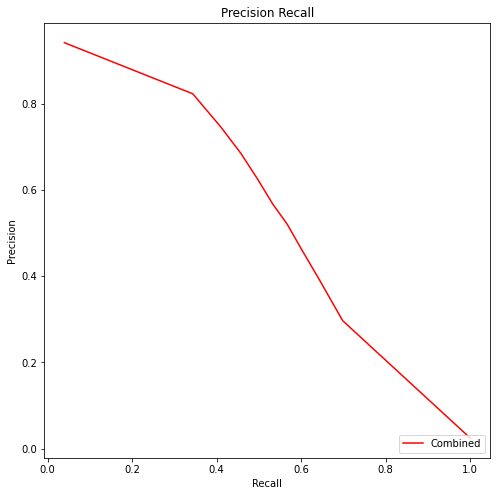

In [13]:
plt.figure(figsize=(8, 8))
x = pr[:, 0]
y = pr[:, 1]
plt.plot(x, y, 'r-',label='Combined')

plt.title('Precision Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc='lower right')
#plt.savefig('graphics/Accuracy.png')
plt.show()

In [14]:
def compute_mAP(X, Y):
    #X -> Recall
    #Y -> Precision
    dx = np.diff(X)
    X_ = np.array([])
    Y_ = np.array([])
    
    eps = 5e-3
    for i in range(len(dx)):
        if dx[i] > eps:
            x0 = X[i]; x1 = X[i+1]
            y0 = Y[i]; y1 = Y[i+1]
            a = (y1 - y0) / (x1 - x0)
            b = y0 - a * x0
            x = np.arange(x0, x1, eps)
            y = a * x + b                
            X_ = np.concatenate((X_, x))
            Y_ = np.concatenate((Y_, y))
        else:
            X_ = np.concatenate((X_, X[i:i+1]))
            Y_ = np.concatenate((Y_, Y[i:i+1]))
                    
    X_ = np.concatenate((X_, X[-1:]))
    Y_ = np.concatenate((Y_, Y[-1:]))
    
    new_dx = np.diff(X_)
    map_ = 100 * np.inner(Y_[:-1], new_dx)
    
    return map_

mAP:  52.40700645690535


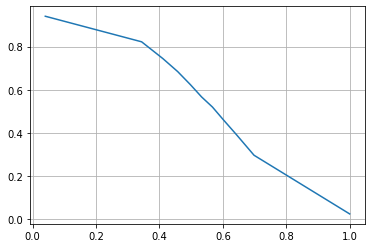

In [24]:
Recall = pr[:,0]
Precision = pr[:,1]

mAP = compute_mAP(Recall, Precision)
print('mAP: ', mAP)

plt.close('all')
plt.plot(Recall, Precision)
plt.grid()

In [25]:
import numpy as np
import skimage.morphology
from sklearn.metrics import confusion_matrix

def compute_matrics(thresholds, prob_map, labels, test_mask, area_no_considered):   
    metrics_all = []
    
    for thr in thresholds:
        print(thr)  

        img_reconstructed = np.zeros_like(prob_map).astype(np.int8)
        img_reconstructed[prob_map >= thr] = 1
        
        # Mask to remove areas < 6.25 ha
        mask_areas_pred = np.ones_like(labels)
        area = skimage.morphology.area_opening(img_reconstructed, area_threshold = area_no_considered, connectivity=1)
        area_no_consider = img_reconstructed-area
        mask_areas_pred[area_no_consider==1] = 0
        
        # Mask of edges no considered 
        mask_borders = np.ones_like(img_reconstructed)
        mask_borders[labels==2] = 0
        
        mask_no_consider = mask_areas_pred * mask_borders 
        ref_consider = mask_no_consider * labels
        pred_consider = mask_no_consider*img_reconstructed
        
        ref_final = ref_consider[test_mask==1]
        pre_final = pred_consider[test_mask==1]
        
        # Metrics
        cm = confusion_matrix(ref_final, pre_final)
        #TN = cm[0,0]
        FN = cm[1,0]
        TP = cm[1,1]
        FP = cm[0,1]
        precision_ = TP/(TP+FP)
        recall_ = TP/(TP+FN)
        rec_pre = np.hstack((recall_, precision_))
        metrics_all.append(rec_pre)
    out_metrics = np.asarray(metrics_all)
    return out_metrics


In [ ]:
test_mask = np.zeros_like(labels)
test_tiles = [2, 4, 5, 9, 10, 11, 13, 15, 18]
split_v = 6
split_h = 3
lines = np.array_split(range(labels.shape[0]), split_v)
cols = np.array_split(range(labels.shape[1]), split_h)
i = 0
dic = {}
for line in lines:
    for col in cols:
        i+=1
        if i not in test_tiles:
            continue
        test_mask[line[0]:line[-1]+1, col[0]:col[-1]+1] = 1
print(np.unique(test_mask))
Image.fromarray(np.uint8(255*test_mask))

In [26]:
# Load data
mean_prob = np.load('D:\\Doutorado PUC\\Deep Learning 2\\Projeto\\cross-fusion\\pred_2\\fusion.npy')
final_mask1 = np.load('D:\\Doutorado PUC\\Deep Learning 2\\Projeto\\cross-fusion\\imgs\\label\\labels.npy')
#test_mask = np.load('your test mask')



ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = test_mask * ref1
GTTruePositives = final_mask1==1
    
Npoints = 10#50
Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,0,Npoints)
    
rec_pre_metrics = compute_matrics(ProbList, mean_prob, final_mask1, test_mask, 625)
#np.save(path_exp+'/acc_metrics.npy',rec_pre_metrics)

1.0
0.8888888888888888
0.7777777777777778
0.6666666666666667
0.5555555555555556
0.4444444444444444
0.33333333333333337
0.22222222222222232
0.11111111111111116
0.0


mAP:  52.35227693250122


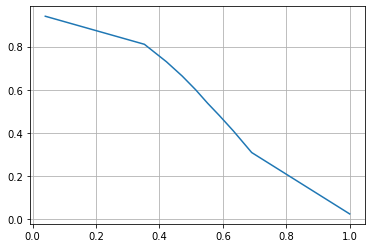

In [27]:
# Compute mean average prcision
Recall = rec_pre_metrics[:,0]
Precision = rec_pre_metrics[:,1]

mAP = compute_mAP(Recall, Precision)
print('mAP: ', mAP)

plt.close('all')
plt.plot(Recall, Precision)
plt.grid()